In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set_style("whitegrid")
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from causalml.inference.meta import BaseRLearner, BaseTLearner, BaseXRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

In [4]:
regions = pd.read_csv("ETA_AB_Regions (1).csv")
ride = pd.read_csv("ETA_Ride (1).csv")
rps = pd.read_csv('ETA_RPS (1).csv')


In [5]:
###### read and aggregate rps data
rps = rps.groupby(['rideId'], as_index = False).agg({'rankTime': 'max', 'isAccept': 'sum'})
rps.columns = ['rideId', 'numDrivers', 'driversAccept']

In [6]:
####### merge ride data with regions
ride = ride.merge(regions, on = 'regionId', how = 'left')

In [7]:
df = rps.merge(ride, on = 'rideId', how = 'left')

##### convert id columns to str
df['rideId'] = df['rideId'].astype(str)
df['regionId'] = df['regionId'].astype(str)

####### convert date and compute hour of day
df['createdAt'] = pd.to_datetime(df['createdAt'], format = "%Y-%m-%d")
df['hour'] = df['createdAt'].dt.hour

######## acceptance rate
df['DriverAcceptanceRate'] = df['driversAccept'] / df['numDrivers']

In [8]:
df.head()

,rideId,numDrivers,driversAccept,createdAt,isAssigned,price,regionId,isTreatment,hour,DriverAcceptanceRate
0,4,1,0,2020-10-04 07:43:56.560000+03:30,0.0,88000.0,770,0,7,0.0
1,6,1,1,2020-10-04 07:54:09.933000+03:30,1.0,89000.0,770,0,7,1.0
2,8,1,0,2020-10-04 07:41:12.633000+03:30,0.0,88000.0,770,0,7,0.0
3,10,3,0,2020-10-04 11:10:04.083000+03:30,0.0,6500.0,771,0,11,0.0
4,11,1,0,2020-10-04 16:14:22.557000+03:30,0.0,63000.0,771,0,16,0.0


# ATE and CATE by Causal Inference

### ATE
The average treatment effect (ATE) is a measure used to compare treatments (or interventions) in randomized experiments. The ATE measures the difference in mean (average) outcomes between units assigned to the treatment and units assigned to the control.


### CATE

to better understanding of  effect of a treatment, we divide the study data into subgroups (e.g., hour of ride request, ...), and see if the average treatment effects are different by subgroup. A per-subgroup ATE is called a "conditional average treatment effect" (CATE), i.e. the ATE conditioned on membership in the subgroup.

## 1) Causal inference on Driver Acceptance rate

In [9]:
acceptance = df[['isTreatment', 'hour', 'DriverAcceptanceRate']].copy()
#acceptance['price_range'] = pd.qcut(acceptance['price'], q = 4, labels = [1,2,3,4])

In [10]:
acceptance

,isTreatment,hour,DriverAcceptanceRate
0,0,7,0.0
1,0,7,1.0
2,0,7,0.0
3,0,11,0.0
4,0,16,0.0
...,...,...,...
55551,1,18,1.0
55552,1,10,1.0
55553,1,12,1.0
55554,1,9,1.0


In [11]:
learn_r = BaseRLearner(learner=XGBRegressor())

### 1-1) Acceptance rate ATE 

In [12]:
ate, ate_lower, ate_upper = learn_r.estimate_ate(X = acceptance[['hour']],
                     treatment=acceptance['isTreatment'],
                     y = acceptance['DriverAcceptanceRate'])

print("ATE for driver acceptance rate using R-Learner: ",ate[0])

ATE for driver acceptance rate using R-Learner:  0.0006683147074173916


ATE is difference beteween mean of treatment group and mean of control group, which shows that treatment group mean in acceptance rate is 0.000619661153345577 higher.

### 1-2) Acceptance Rate CATE

we divide data by hours of rides to evaluate ATE in subgroups (hours.)

In [13]:
cate = learn_r.fit_predict(X = acceptance['hour'].values.reshape(-1,1),
                     treatment=acceptance['isTreatment'],
                     y = acceptance['DriverAcceptanceRate'])

acceptance['CATE'] = cate

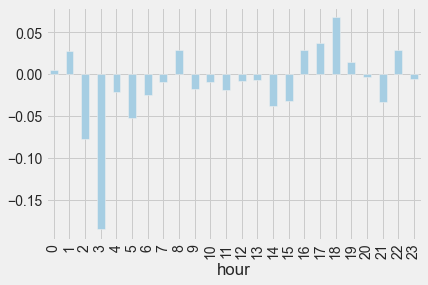

In [14]:
acceptance.groupby(['hour'])['CATE'].mean().plot(kind = 'bar')

## 2) causal inference in Price

### 2-1) ATE on Price

In [15]:
price = df[['isTreatment', 'hour', 'price']].copy()


In [16]:
learn_r = BaseRLearner(learner=XGBRegressor())

ate, ate_lower, ate_upper = learn_r.estimate_ate(X = price[['hour']],
                     treatment=price['isTreatment'],
                     y = price['price'])

print("ATE for Price using R-Learner: ",ate[0])

ATE for Price using R-Learner:  -1342.4000804843652


difference between mean of price in treatmen group and mean of price in control group is -1343

### 2-2) CATE on price

In [17]:
cate = learn_r.fit_predict(X = price[['hour']],
                     treatment=price['isTreatment'],
                     y = price['price'])

price['CATE'] = cate

Text(0, 0.5, 'Price CATE')

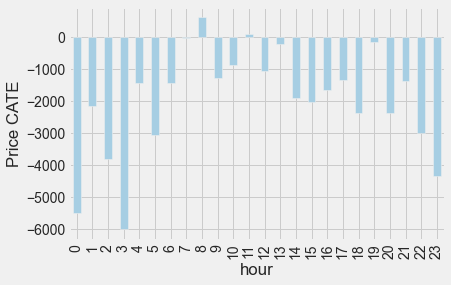

In [18]:
price.groupby(['hour'])['CATE'].mean().plot(kind = 'bar')
plt.ylabel('Price CATE')

## 3) Different Learners
in this section i will use group of learners to estimate treatment effect on price

In [19]:
from causalml.inference.meta import BaseRLearner, BaseSLearner, BaseTLearner, BaseXLearner

price = df[['isTreatment', 'hour', 'price']].copy()


learners = [('R-learner', BaseRLearner(learner=XGBRegressor())),
           ('S-learner', BaseSLearner(learner=XGBRegressor())),
           ('T-learner', BaseTLearner(learner=XGBRegressor())),
           ('X-learner', BaseXLearner(learner=XGBRegressor()))]

for learner_name, learner in learners:
    print(learner_name)
    cate = learner.fit_predict(X = price[['hour']],
                     treatment=price['isTreatment'],
                     y = price['price'])
    price[learner_name] = cate

R-learner
S-learner
T-learner
X-learner


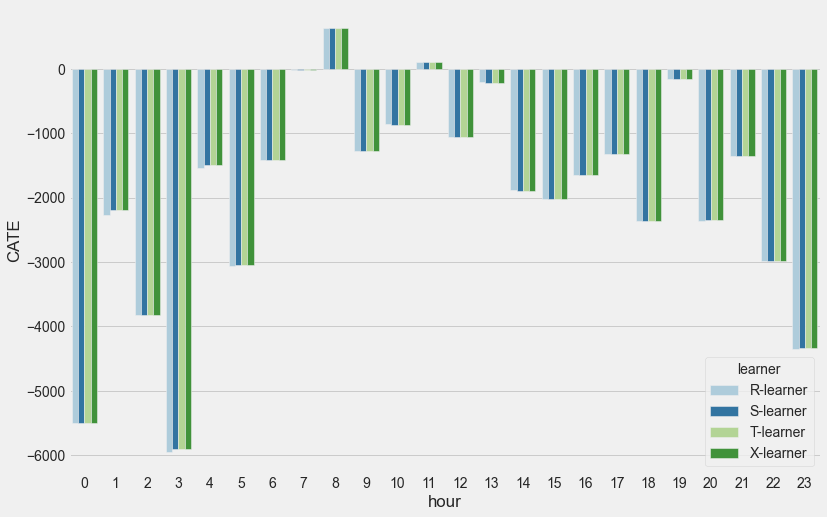

In [20]:
price_cate = pd.melt(price.groupby(['hour'], as_index = False)[[i[0] for i in learners]].mean(), id_vars='hour',
                    var_name='learner', value_name='CATE')


plt.figure(figsize = (12,8))
sns.barplot(x = 'hour', y = 'CATE', hue = 'learner', data = price_cate)
plt.show()

as shown in plot above, for many hours difference between mean of price in treatment and control is negative, which means for most hours on average, treatment group has lower price.

now I will use same approach for driver acceptance rate.

In [21]:
acceptance = df[['isTreatment', 'hour', 'DriverAcceptanceRate']].copy()


learners = [('R-learner', BaseRLearner(learner=XGBRegressor())),
           ('S-learner', BaseSLearner(learner=XGBRegressor())),
           ('T-learner', BaseTLearner(learner=XGBRegressor())),
           ('X-learner', BaseXLearner(learner=XGBRegressor()))]

for learner_name, learner in learners:
    print(learner_name)
    cate = learner.fit_predict(X = acceptance[['hour']],
                     treatment=acceptance['isTreatment'],
                     y = acceptance['DriverAcceptanceRate'])
    acceptance[learner_name] = cate

R-learner
S-learner
T-learner
X-learner


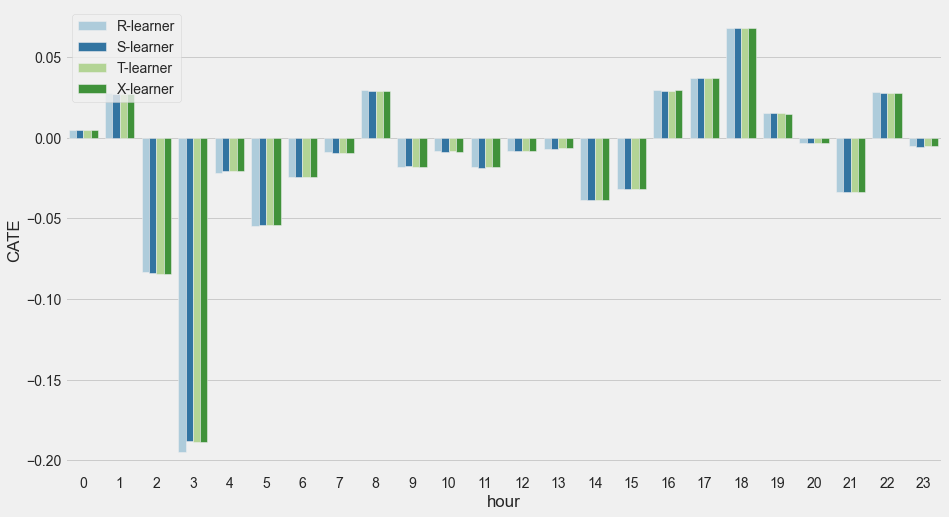

In [22]:
acceptance_cate = pd.melt(acceptance.groupby(['hour'], as_index = False)[[i[0] for i in learners]].mean(), id_vars='hour',
                    var_name='learner', value_name='CATE')


plt.figure(figsize = (14,8))
sns.barplot(x = 'hour', y = 'CATE', hue = 'learner', data = acceptance_cate)
plt.legend(loc = 2)
plt.show()

as computed above Total ATE for driver acceptance rate was +0.00062 which is a low number. but if we divide data into subgroups and compute CATEs per groups we could see larger differences in means of accteptance rate between groups.

for example for evening time (between 16 and 19) treatment group has higher acceptance rate mean than control group but in the morning (8 to 11) treament has lower acceptance rate mean.

for hour 18 as shown in table below, acceptance rate mean of treatment group is 0.068 higher than control group.

In [23]:
acceptance.groupby(['hour'])[[i[0] for i in learners]].mean()

,R-learner,S-learner,T-learner,X-learner
hour,,,,
0,0.004636,0.004648,0.004654,0.004664
1,0.027902,0.027019,0.027072,0.027047
2,-0.083243,-0.084180,-0.084198,-0.084205
3,-0.195018,-0.188434,-0.188806,-0.188546
4,-0.022065,-0.020555,-0.020350,-0.020539
5,-0.054413,-0.054101,-0.054225,-0.054098
6,-0.024455,-0.024550,-0.024557,-0.024572
7,-0.009055,-0.009488,-0.009488,-0.009467
8,0.029651,0.029069,0.029348,0.029328


### Plot CATEs against Total income

In [53]:
income = df[['isTreatment', 'isAssigned', 'price', 'hour']].copy()

#### only select assigned rides to compute income
income = income[income['isAssigned'] == 1]

###### sum prices for each hour per groups
income = income.groupby(['isTreatment','hour'], as_index = False).agg({'price': 'sum'})
income.rename(columns = {'price': 'Total Income'}, inplace = True)

###### from CATEs computed above I will use X-learner for plotting
price_cates = price.groupby(['hour'],as_index = False).agg({'X-learner':'mean'})
price_cates.rename(columns = {'X-learner': 'AvgPriceDiff'}, inplace = True)

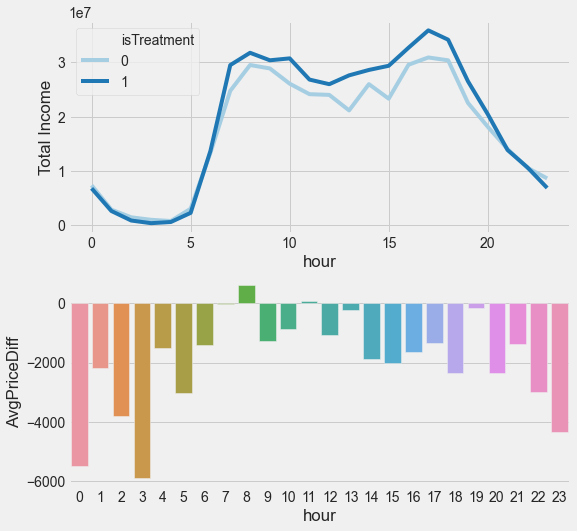

In [55]:
fig, ax = plt.subplots(2, figsize = (8,8))
sns.lineplot(x = 'hour', y = 'Total Income', hue = 'isTreatment', data = income, ax = ax[0])
sns.barplot(x = 'hour', y = 'AvgPriceDiff', data = price_cates, ax = ax[1])

plot above shows that while treatment group average price is less than control group mean for most of the hours, but total income (sum of prices from successful rides) in treatment group is more than control group for most of the hours. 

below is total income from treatment and control group and shows better income from treatment group. treatment group has caused 11% higher income in comparison to control group.

In [57]:
income.groupby(['isTreatment'])['Total Income'].sum()

isTreatment
0    422113500.0
1    468824500.0
Name: Total Income, dtype: float64

In [65]:
print('difference in total income between treatment and control: ', round(100 * (468824500.0 - 422113500.0) / 422113500.0),'%')

difference in total income between treatment and control:  11 %


In [70]:
###### plot income difference (in %) per hour
income_pivoted = pd.pivot_table(income,index = 'hour', columns = ['isTreatment'], values = ['Total Income'])
income_pivoted['IncomeDiff%'] = 100 * (income_pivoted[('Total Income', 1)] - income_pivoted[('Total Income', 0)]) / income_pivoted[('Total Income', 0)]

Text(0, 0.5, 'Income Difference %')

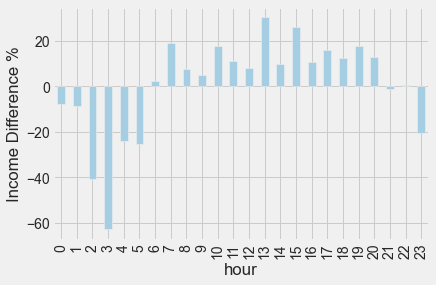

In [75]:
income_pivoted['IncomeDiff%'].plot(kind = 'bar')
plt.ylabel("Income Difference %")

during first hours of the day (0 to 6) treatment groups has lower income but for most of busy hours (7 to 20), it's obvious that treatment group caused increase in income and total income of day was 11% higher from treatment group.

In [78]:
income_pivoted

Total Income             IncomeDiff%
isTreatment            0           1            
hour                                            
0              7337000.0   6781500.0   -7.571214
1              2855500.0   2607000.0   -8.702504
2              1449000.0    856500.0  -40.890269
3               990000.0    368000.0  -62.828283
4               767000.0    582500.0  -24.054759
5              3029500.0   2266000.0  -25.202179
6             13336500.0  13686000.0    2.620628
7             24738000.0  29481000.0   19.172932
8             29497000.0  31749500.0    7.636370
9             28865000.0  30368000.0    5.206998
10            26059500.0  30720000.0   17.884073
11            24128000.0  26814500.0   11.134367
12            23994000.0  25966500.0    8.220805
13            21138000.0  27594000.0   30.542152
14            25971000.0  28589500.0   10.082400
15            23298500.0  29356000.0   25.999528
16            29547000.0  32680000.0   10.603445
17            30889500.0  35876500.0   16.144645
18            30362500.0  34161500.0   12.512145
19            22526000.0  26508000.0   17.677351
20            18128000.0  20447500.0   12.795124
21            14023500.0  13845000.0   -1.272863
22            10572000.0  10660000.0    0.832387
23             8611500.0   6859500.0  -20.344888

for hour 3, which income from treatment is 60 % less than control group each income is less than 1,000,000. but for hour 15 that treatment group has 26% higher income, difference between incomes are nearly 6,000,000. as mentioned above this shows that for hours with high demand of rides income from treatment group was higher and led to increase in final income (11%) at the end of day.